In [2]:
import numpy as np
import pandas as pd
from keras.models import load_model
from math import pi
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
import holidays
from datetime import timedelta
np.set_printoptions(threshold=np.nan)

<h1>Load Model</h1>

In [3]:
class HolidaySelector(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        hd = [date for date, name in holidays.US(years=[2013, 2014, 2015, 2016, 2017, 2018]).items()
                        if name.startswith(("New Year's Day", "Washington's Birthday", "Memorial Day", "Independence Date",
                        "Labor Day", "Thanksgiving", "Christmas Day"))]
        hd_eve = [day - timedelta(days=1) for day in hd]
        hd.extend(hd_eve)
        self.h = [str(date) for date in hd]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[['date']].applymap(lambda x: int(pd.to_datetime(x).strftime('%Y-%m-%d') in self.h))

class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.loc[:, self.columns]
    
class DateTimeExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, extract):
        self.extract = extract
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X[['date']].applymap(lambda x: float(getattr(pd.to_datetime(x), self.extract)))

class CosExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.unique = X.nunique()
        return self
        
    def transform(self, X, y=None):
        return X.apply(lambda x: np.round(np.cos(x * pi * 2/ self.unique), 5), axis=1)

class SinExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.unique = X.nunique()
        return self
        
    def transform(self, X, y=None):
        return X.apply(lambda x: np.round(np.sin(x * pi * 2/ self.unique), 5), axis=1)

    
class LagTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, amount):
        self.amount=amount
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[['rides']].shift(self.amount, fill_value=0)

In [4]:
xg = joblib.load('./model/xg.pkl')
all_pipeline = joblib.load('./model/all_pipeline.pkl')
time_pipeline = joblib.load('./model/time_pipeline.pkl')
model = load_model('./model/dl.h5')

<h1>Load Data</h1>

In [5]:
data = pd.read_csv('./actuals.csv')

train_cut = int(len(data) * 0.8)
validate_cut = int(len(data) * 0.9)
test_cut = int(len(data))

In [6]:
data.head()

,date,sunrise,icon,precip_prob,temperature,humidity,wind_speed,rides
0,2013-06-01 00:00:00,0,clear,0.01,77.65,0.61,2.06,152
1,2013-06-01 01:00:00,0,clear,0.01,75.62,0.67,1.93,102
2,2013-06-01 02:00:00,0,clear,0.01,74.72,0.70,2.31,67
3,2013-06-01 03:00:00,0,clear,0.01,73.32,0.76,2.16,41
4,2013-06-01 04:00:00,0,clear,0.01,72.42,0.79,1.93,16


<h1>XG Prediction</h1>

In [7]:
xg_preds = xg.predict(data.iloc[validate_cut:test_cut, :])
mean_squared_error(xg_preds, data.iloc[validate_cut:test_cut, 7])

216830.6257858591

<h1>DL Prediction</h1>

In [8]:
def create_datasets(time_X, all_X, start, stop):
    ONE_DAY = 24
    lookback = 28*ONE_DAY 
    lag = 2*ONE_DAY 
    
    if start < lookback + lag:
        start = lookback + lag

    input_time_X = np.zeros((stop-start, lookback//ONE_DAY, len(time_X[0])))
    input_all_X = np.zeros((stop-start, len(all_X[0])))
    
    for i in range(start, stop):
        input_time_X[i-start] = time_X[i-lookback-lag:i-lag:ONE_DAY]
        input_all_X[i-start] = all_X[i]
    
    return [input_time_X, input_all_X]

In [9]:
all_X = all_pipeline.transform(data)
time_X = time_pipeline.transform(data)

dl_preds = model.predict(create_datasets(time_X, all_X, validate_cut, test_cut))
mean_squared_error(dl_preds[:, 0], data.iloc[validate_cut:test_cut, 7])


243263.55242214174

<h1>Ensemble Model</h1>

In [10]:
predictions = (xg_preds + dl_preds[:, 0]) / 2
predictions[0:5]

array([1310.7666, 1104.7056,  816.5654,  517.3077,  299.6802],
      dtype=float32)

In [11]:
mean_squared_error(predictions, data.iloc[validate_cut:test_cut, 7])

155964.8390602782

<h1>Examination</h1>

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ['R_HOME'] = r'C:\Program Files\R\R-3.4.4'

%matplotlib inline
%load_ext rpy2.ipython

In [13]:
%%R
install.packages('tidyverse')
library(tidyverse)

In [14]:
explore = DataFrame({'date': data.iloc[validate_cut:test_cut, 0], 
                     'rides': data.iloc[validate_cut:test_cut, 7], 
                     'preds': predictions})

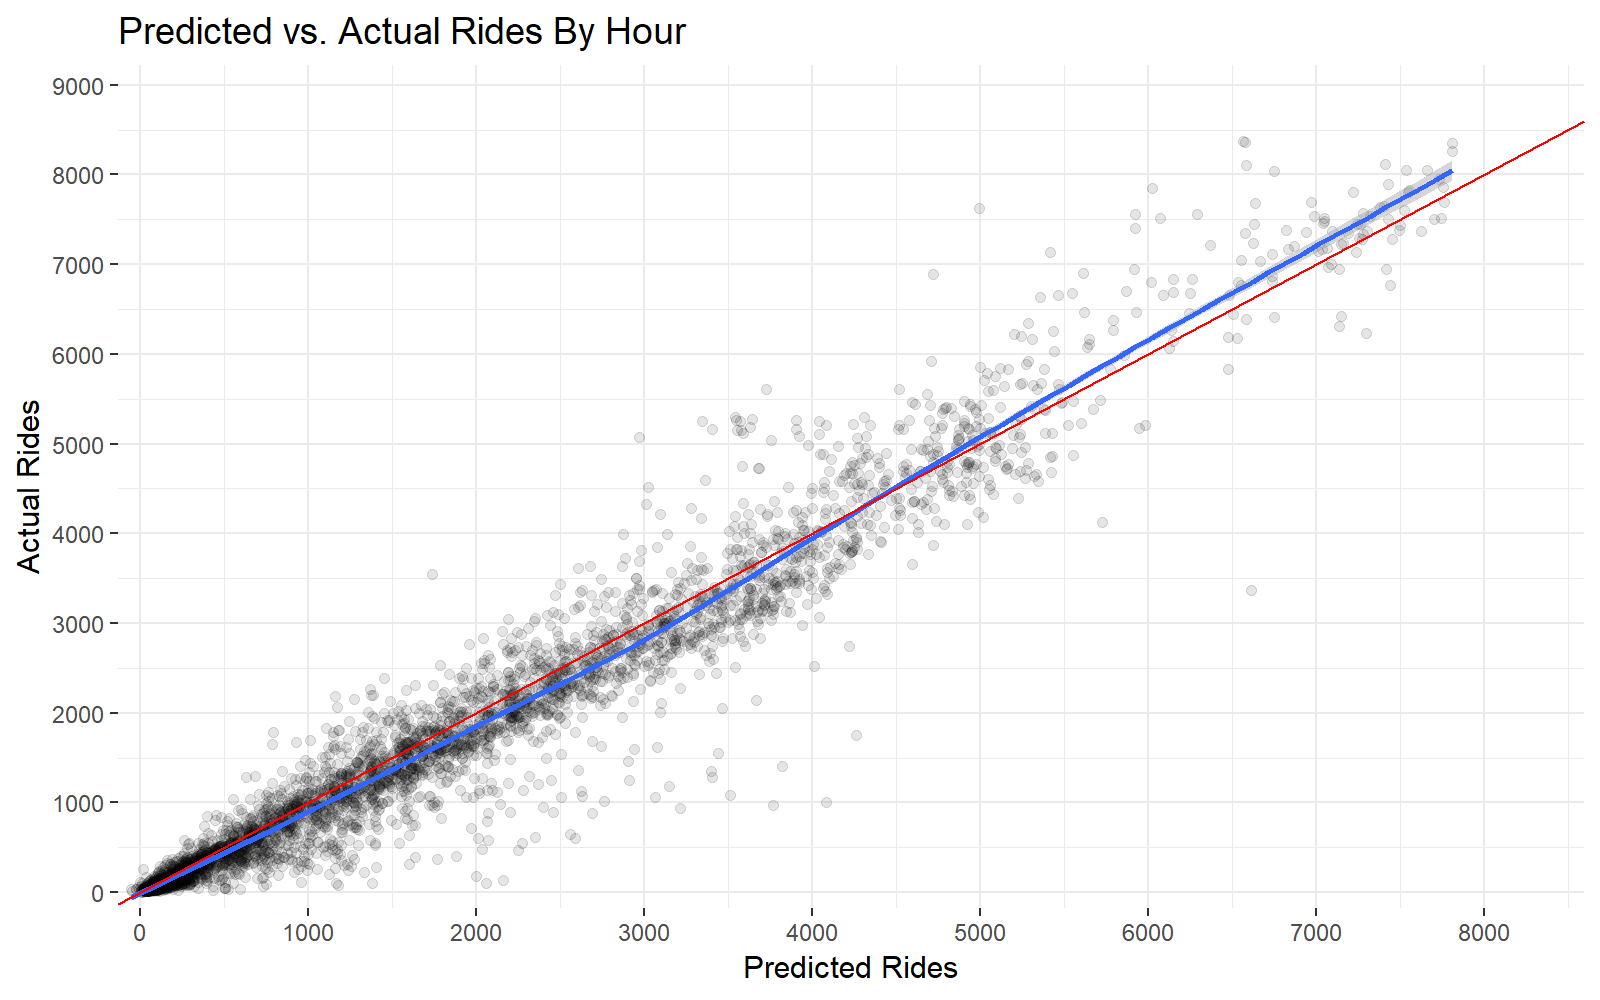

In [17]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  ggplot(aes(preds, rides)) +
  geom_point(alpha=0.1) +
  geom_smooth() +
  geom_abline(slope=1, intercept=0, color='red') +
  labs(x='Predicted Rides',
       y='Actual Rides',
       title='Predicted vs. Actual Rides By Hour') + 
  scale_x_continuous(labels=seq(0, 9000, 1000), breaks=seq(0, 9000, 1000), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(labels=seq(0, 9000, 1000), breaks=seq(0, 9000, 1000), expand=c(0.01, 0.1, 0.1, 0)) +
  theme_bw() +
  theme(panel.border = element_blank())

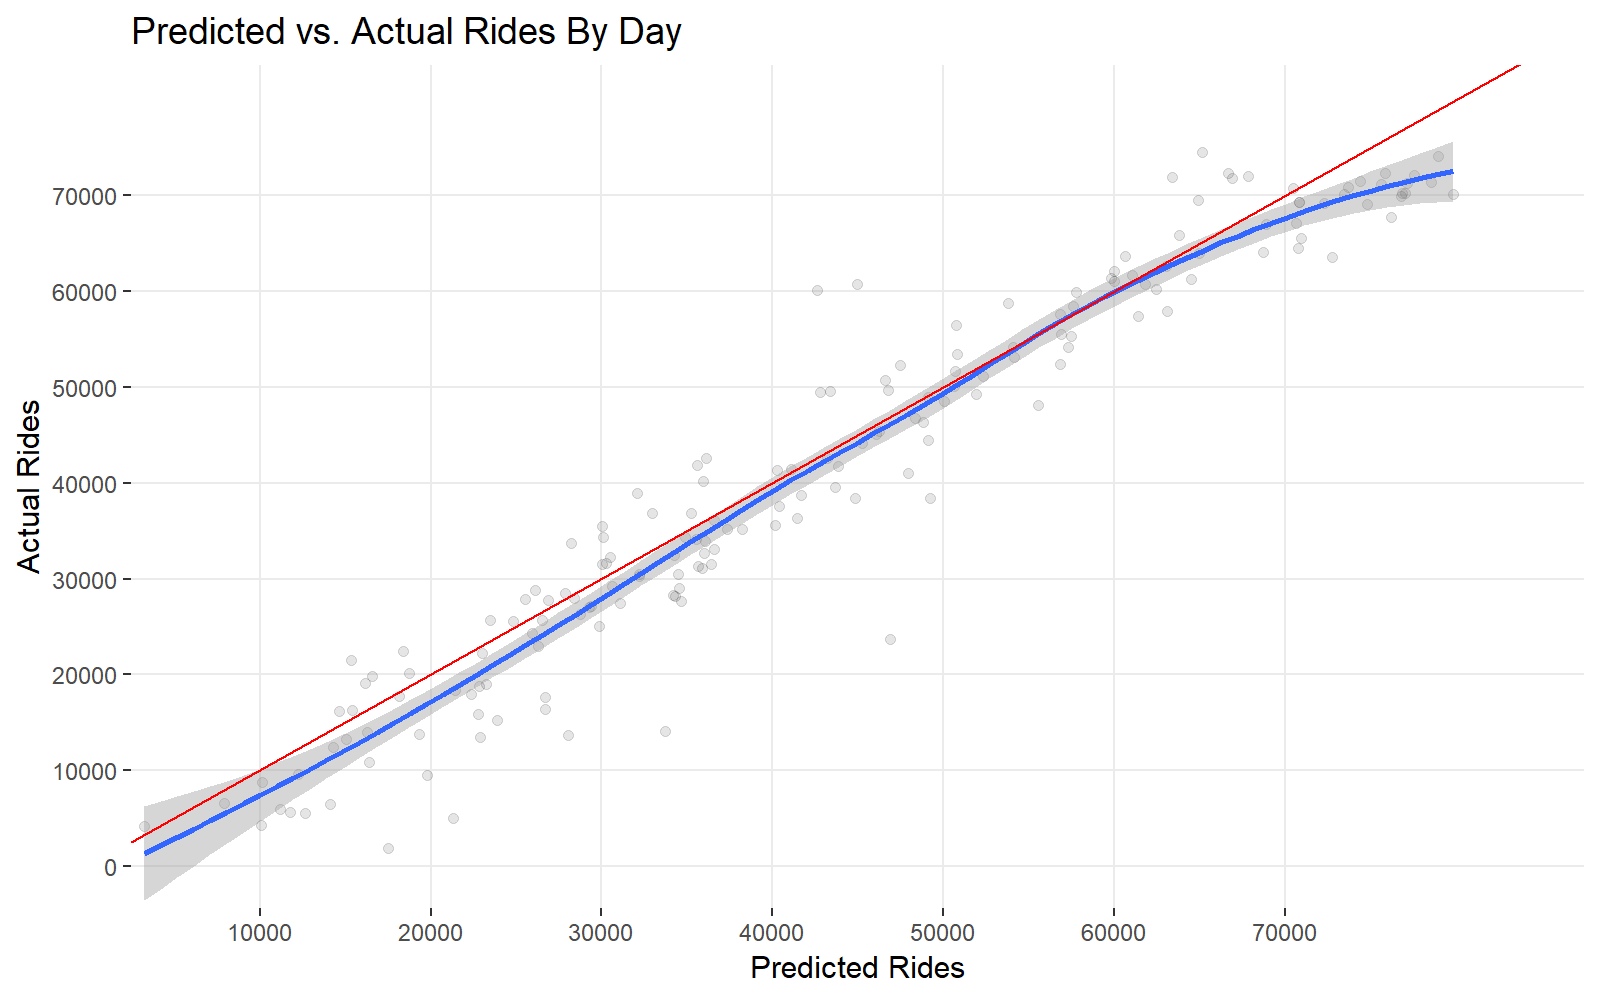

In [19]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  mutate(d = substr(date, 0, 10)) %>%
  group_by(d) %>%
  summarize(preds = sum(preds),
            rides = sum(rides)) %>%
  ggplot(aes(preds, rides)) +
  geom_point(alpha=0.1) +
  geom_smooth() +
  geom_abline(slope=1, intercept=0, color='red') +
  labs(x='Predicted Rides',
       y='Actual Rides',
       title='Predicted vs. Actual Rides By Day') + 
  scale_x_continuous(labels=seq(0, 70000, 10000), breaks=seq(0, 70000, 10000), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(labels=seq(0, 70000, 10000), breaks=seq(0, 70000, 10000), expand=c(0.01, 0.1, 0.1, 0)) +
  theme_bw() +
  theme(panel.border = element_blank(),
        panel.grid.minor = element_blank())

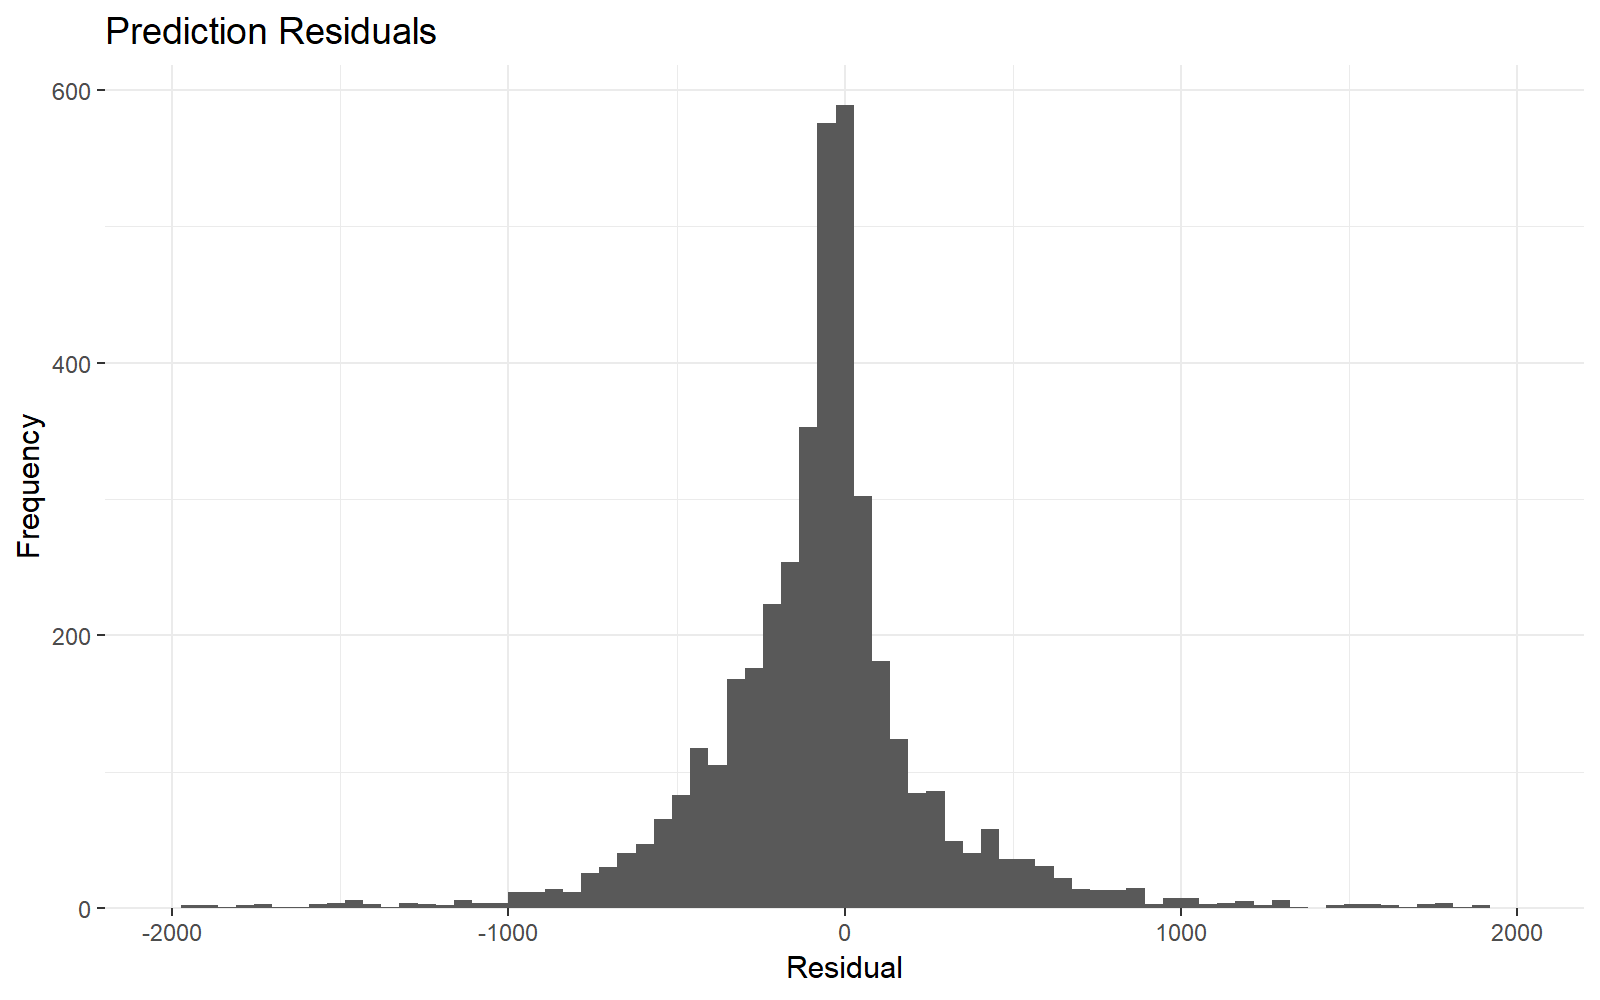

In [20]:
%%R -i explore -w 8 -h 5 --units in -r 200
explore %>%
  mutate(resid = rides - preds) %>%
  ggplot(aes(resid)) +
  geom_histogram(bins=75) +
  labs(x='Residual',
       y='Frequency',
       title='Prediction Residuals') +
  scale_x_continuous(labels=seq(-2000, 2000, 500), breaks=seq(-2000, 2000, 500), expand=c(0.01, 0.1, 0.1, 0)) +
  scale_y_continuous(expand=c(0, 0, 0.05, 0)) +
  xlim(-2000, 2000) +
  theme_bw() +
  theme(panel.border = element_blank())
  